In [1]:
%matplotlib inline

Simple example of two-session fMRI model fitting
================================================

Full step-by-step example of fitting a GLM to experimental data and visualizing
the results. This is done on two runs of one subject of the FIAC dataset.

For details on the data, please see:

Dehaene-Lambertz G, Dehaene S, Anton JL, Campagne A, Ciuciu P, Dehaene
G, Denghien I, Jobert A, LeBihan D, Sigman M, Pallier C, Poline
JB. Functional segregation of cortical language areas by sentence
repetition. Hum Brain Mapp. 2006: 27:360--371.
http://www.pubmedcentral.nih.gov/articlerender.fcgi?artid=2653076#R11

More specifically:

1. A sequence of fMRI volumes are loaded
2. A design matrix describing all the effects related to the data is computed
3. a mask of the useful brain volume is computed
4. A GLM is applied to the dataset (effect/covariance,
   then contrast estimation)

Technically, this example shows how to handle two sessions that
contain the same experimental conditions. The model directly returns a
fixed effect of the statistics across the two sessions.




Create a write directory to work
it will be a 'results' subdirectory of the current directory.



In [2]:
from os import mkdir, path, getcwd
write_dir = path.join(getcwd(), 'results')
if not path.exists(write_dir):
    mkdir(write_dir)

Prepare data and analysis parameters
--------------------------------------

Note that there are two sessions



In [3]:
from nistats import datasets
data = datasets.fetch_fiac_first_level()
fmri_img = [data['func1'], data['func2']]

Create a mean image for plotting purpose



In [4]:
from nilearn.image import mean_img
mean_img_ = mean_img(fmri_img[0])

In [18]:
%matplotlib inline

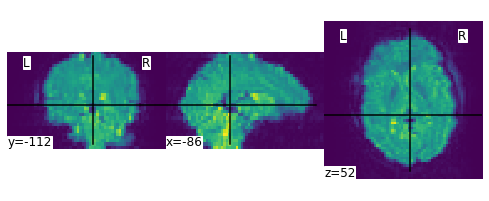

In [19]:
from nilearn.plotting import plot_img
plot_img(mean_img_)

The design matrices were pre-computed, we simply put them in a list of DataFrames



In [7]:
design_files = [data['design_matrix1'], data['design_matrix2']]
import pandas as pd
import numpy as np
design_matrices = [pd.DataFrame(np.load(df)['X']) for df in design_files]

View the design matrix

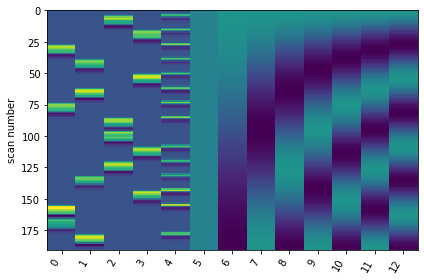

In [20]:
from nistats.reporting import plot_design_matrix
plot_design_matrix(design_matrices[0])

GLM estimation
----------------------------------
GLM specification. Note that the mask was provided in the dataset. So we use it.



In [27]:
from nistats.first_level_model import FirstLevelModel
fmri_glm = FirstLevelModel(mask=data['mask'], minimize_memory=True, drift_model='polynomial', )

GLM fitting



In [10]:
fmri_glm = fmri_glm.fit(fmri_img, design_matrices=design_matrices)

/home/data/cis/training-week-2019/env/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/data/cis/training-week-2019/env/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/data/cis/training-week-2019/env/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and me

Compute fixed effects of the two runs and compute related images
For this, we first define the contrasts as we would do for a single session



In [11]:
n_columns = design_matrices[0].shape[1]

def pad_vector(contrast_, n_columns):
    """A small routine to append zeros in contrast vectors"""
    return np.hstack((contrast_, np.zeros(n_columns - len(contrast_))))

Contrast specification



In [12]:
contrasts = {'SStSSp_minus_DStDSp': pad_vector([1, 0, 0, -1], n_columns),
             'DStDSp_minus_SStSSp': pad_vector([-1, 0, 0, 1], n_columns),
             'DSt_minus_SSt': pad_vector([-1, -1, 1, 1], n_columns),
             'DSp_minus_SSp': pad_vector([-1, 1, -1, 1], n_columns),
             'DSt_minus_SSt_for_DSp': pad_vector([0, -1, 0, 1], n_columns),
             'DSp_minus_SSp_for_DSt': pad_vector([0, 0, -1, 1], n_columns),
             'Deactivation': pad_vector([-1, -1, -1, -1, 4], n_columns),
             'Effects_of_interest': np.eye(n_columns)[:5]}

Compute and plot statistics



In [21]:
from nilearn import plotting
print('Computing contrasts...')
for index, (contrast_id, contrast_val) in enumerate(contrasts.items()):
    print('  Contrast % 2i out of %i: %s' % (
        index + 1, len(contrasts), contrast_id))
    # estimate the contasts
    # note that the model implictly compute a fixed effects across the two sessions
    z_map = fmri_glm.compute_contrast(
        contrast_val, output_type='z_score')

    # Write the resulting stat images to file 
    z_image_path = path.join(write_dir, '%s_z_map.nii.gz' % contrast_id)
    z_map.to_filename(z_image_path)

Computing contrasts...
  Contrast  1 out of 8: SStSSp_minus_DStDSp
  Contrast  2 out of 8: DStDSp_minus_SStSSp
  Contrast  3 out of 8: DSt_minus_SSt
  Contrast  4 out of 8: DSp_minus_SSp
  Contrast  5 out of 8: DSt_minus_SSt_for_DSp
  Contrast  6 out of 8: DSp_minus_SSp_for_DSt
  Contrast  7 out of 8: Deactivation
  Contrast  8 out of 8: Effects_of_interest


Comparing session-specific and fixed effects.
Here, we compare the activation mas produced from each separately then, the fixed effects version



In [22]:
contrast_id = 'Effects_of_interest'

Statistics for the first session



/home/data/cis/training-week-2019/env/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/data/cis/training-week-2019/env/lib/python3.6/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


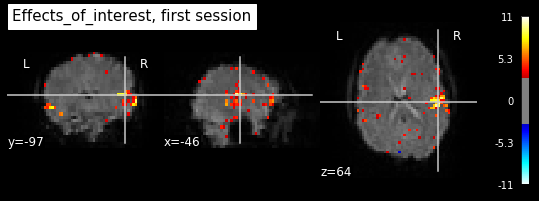

In [23]:
fmri_glm = fmri_glm.fit(fmri_img[0], design_matrices=design_matrices[0])
z_map = fmri_glm.compute_contrast(
        contrasts[contrast_id], output_type='z_score')
plotting.plot_stat_map(
    z_map, bg_img=mean_img_, threshold=3.0,
    title='%s, first session' % contrast_id)

Statistics for the second session



/home/data/cis/training-week-2019/env/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/data/cis/training-week-2019/env/lib/python3.6/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


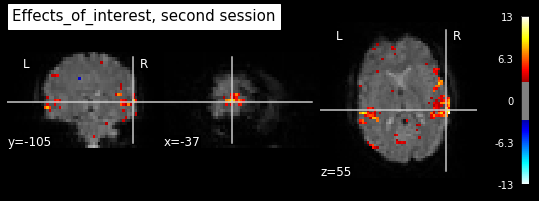

In [24]:
fmri_glm = fmri_glm.fit(fmri_img[1], design_matrices=design_matrices[1])
z_map = fmri_glm.compute_contrast(
        contrasts[contrast_id], output_type='z_score')
plotting.plot_stat_map(
    z_map, bg_img=mean_img_, threshold=3.0,
    title='%s, second session' % contrast_id)

Fixed effects statistics



/home/data/cis/training-week-2019/env/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/data/cis/training-week-2019/env/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/data/cis/training-week-2019/env/lib/python3.6/site-packages/nistats/first_level_model.py:542: UserWarning: One contrast given, assuming it for all 2 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)
/home/data/cis/training-week-2019/env/lib/python3.6/site-packages/nistats/contrasts.py:257:

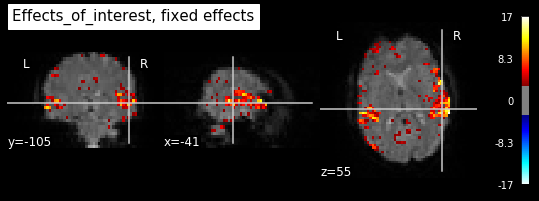

In [25]:
fmri_glm = fmri_glm.fit(fmri_img, design_matrices=design_matrices)
z_map = fmri_glm.compute_contrast(
        contrasts[contrast_id], output_type='z_score')
plotting.plot_stat_map(
    z_map, bg_img=mean_img_, threshold=3.0,
    title='%s, fixed effects' % contrast_id)

Not unexpectedly, the fixed effects version looks displays higher peaks than the input sessions. Computing fixed effects enhances the signal-to-noise ratio of the resulting brain maps

